[*********************100%***********************]  1 of 1 completed


Data Loaded: 2023-03-10 to 2026-01-09

HMM Regime Distribution:
Regime_Label
Vol_Expansion    274
Crash            153
Trend            148
Range            137
Name: count, dtype: int64

Latest GARCH Forecast Vol (in-sample for last data point): 0.3962090690910096
Next day GARCH Forecast Vol (out-of-sample): 0.38651435766218056

Meta-Controller Signal Distribution:
Gamma_Regime
NEUTRAL              326
STRONG_LONG_GAMMA    153
DIRECTIONAL_GAMMA    148
SHORT_GAMMA           50
LONG_GAMMA            35
Name: count, dtype: int64


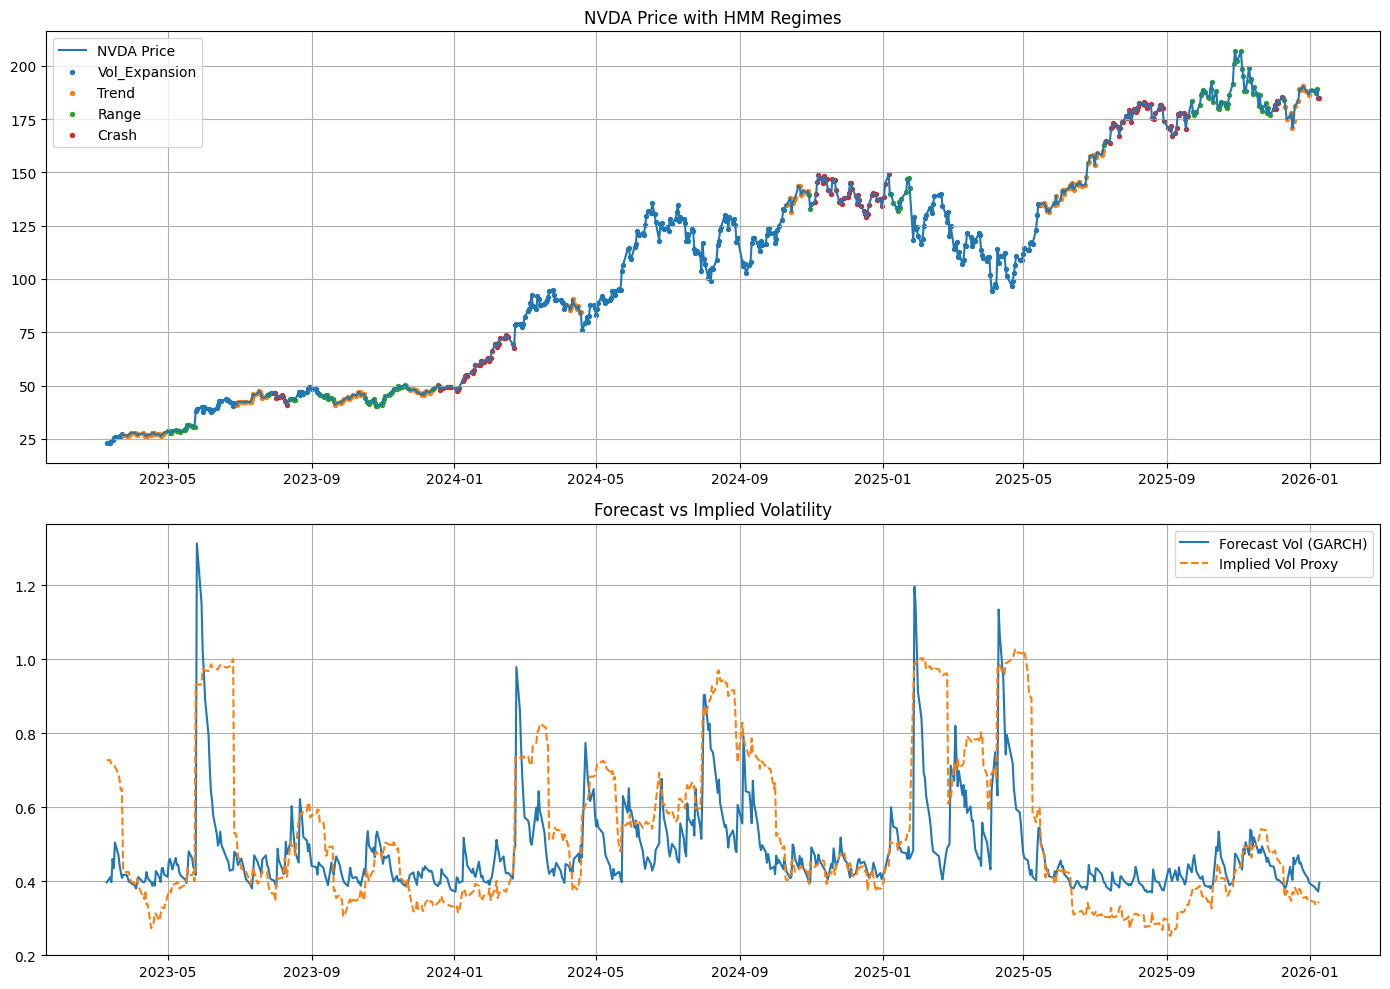

In [29]:
# =========================================================
# PART 1: REGIME + VOLATILITY INTELLIGENCE LAYER
# HMM + GARCH + META CONTROLLER
# =========================================================
# 1. Install packages (once)
!pip install hmmlearn arch scikit-learn
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# =========================================================
# 1. LOAD 3Y NVDA DATA
# =========================================================
ticker = "NVDA"
data = yf.download(ticker, period="3y", auto_adjust=True)
data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
data["realized_vol"] = data["log_return"].rolling(21).std() * np.sqrt(252)
data["vol_of_vol"] = data["realized_vol"].rolling(21).std()
data.dropna(inplace=True)

# Add a risk-free rate column (e.g., a constant value or loaded from another source)
# For demonstration, using a constant annual risk-free rate of 2% (0.02)
data["r"] = 0.02 / 252 # Daily risk-free rate

print("Data Loaded:", data.index[0].date(), "to", data.index[-1].date())

# =========================================================
# 2. HMM REGIME DETECTION
# States: Range / Trend / Vol Expansion / Crash
# =========================================================

features = data[["log_return", "realized_vol", "vol_of_vol"]].values
features_scaled = StandardScaler().fit_transform(features)

hmm = GaussianHMM(n_components=4, covariance_type="full", n_iter=2000)
hmm.fit(features_scaled)

hidden_states = hmm.predict(features_scaled)
data["Regime"] = hidden_states

regime_map = {
    0: "Range",
    1: "Trend",
    2: "Vol_Expansion",
    3: "Crash"
}
data["Regime_Label"] = data["Regime"].map(regime_map)

print("\nHMM Regime Distribution:")
print(data["Regime_Label"].value_counts())

# =========================================================
# 3. GARCH(1,1) VOLATILITY FORECAST
# =========================================================

returns = data["log_return"] * 100
garch = arch_model(returns, vol="Garch", p=1, q=1, dist="normal")
garch_fit = garch.fit(disp="off")

# Use in-sample conditional volatility for the data DataFrame
data["garch_vol_forecast"] = garch_fit.conditional_volatility * np.sqrt(252) / 100

# If you need the *actual* 1-step ahead forecast for the next period (beyond 'data'),
# you can get it separately:
forecast_1step_ahead = garch_fit.forecast(horizon=1)
next_day_forecast_vol = np.sqrt(forecast_1step_ahead.variance.values[-1][0]) * np.sqrt(252) / 100

print("\nLatest GARCH Forecast Vol (in-sample for last data point):", data["garch_vol_forecast"].iloc[-1])
print("Next day GARCH Forecast Vol (out-of-sample):", next_day_forecast_vol)

# =========================================================
# 4. IMPLIED VOLATILITY PROXY (OPTIONS SURFACE APPROX)
# =========================================================

data["implied_vol_proxy"] = data["realized_vol"] * 1.15   # conservative market pricing
data["vol_spread"] = data["garch_vol_forecast"] - data["implied_vol_proxy"]

# ---------------------------
# NEW: 4.5. HAR-RV Forecast (Simple) - Add these back to data pipeline
# ---------------------------
data["RV_1d"] = data["realized_vol"]
data["RV_1w"] = data["realized_vol"].rolling(5).mean()
data["RV_1m"] = data["realized_vol"].rolling(22).mean()

data["HAR_forecast"] = (
    0.5 * data["RV_1d"] +
    0.3 * data["RV_1w"] +
    0.2 * data["RV_1m"]
)

# Blend with GARCH
data["Vol_Forecast"] = 0.5 * data["HAR_forecast"] + 0.5 * data["garch_vol_forecast"]

# ---------------------------
# NEW: 4.6. Volatility Risk Premium Z-Score - Add these back to data pipeline
# ---------------------------
data["VRP"] = data["Vol_Forecast"] - data["implied_vol_proxy"]
data["VRP_Z"] = (data["VRP"] - data["VRP"].rolling(60).mean()) / data["VRP"].rolling(60).std()

# =========================================================
# 5. META-CONTROLLER: GAMMA REGIME SWITCH
# =========================================================

# Use np.select for vectorized conditional logic
conditions = [
    data["Regime_Label"] == "Crash",
    (data["Regime_Label"] == "Vol_Expansion") & (data["vol_spread"] > 0),
    (data["Regime_Label"] == "Range") & (data["vol_spread"] < 0),
    data["Regime_Label"] == "Trend"
]
choices = [
    "STRONG_LONG_GAMMA",
    "LONG_GAMMA",
    "SHORT_GAMMA",
    "DIRECTIONAL_GAMMA"
]

data["Gamma_Regime"] = np.select(conditions, choices, default="NEUTRAL")

print("\nMeta-Controller Signal Distribution:")
print(data["Gamma_Regime"].value_counts())

# =========================================================
# 6. VISUALIZE REGIME & VOL SIGNAL
# =========================================================

fig, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].plot(data.index, data["Close"], label="NVDA Price")
ax[0].set_title("NVDA Price with HMM Regimes")
ax[0].grid(True)

for label in data["Regime_Label"].unique():
    idx = data["Regime_Label"] == label
    ax[0].scatter(data.index[idx], data["Close"][idx], s=8, label=label)

ax[0].legend()

ax[1].plot(data.index, data["garch_vol_forecast"], label="Forecast Vol (GARCH)")
ax[1].plot(data.index, data["implied_vol_proxy"], label="Implied Vol Proxy", linestyle="--")
ax[1].set_title("Forecast vs Implied Volatility")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()



================ VOL ARB FUND PERFORMANCE ================
Sharpe Ratio   : 0.91
CAGR           : 31.71%
Max Drawdown   : -23.56%
Final Capital  : $1,666,851


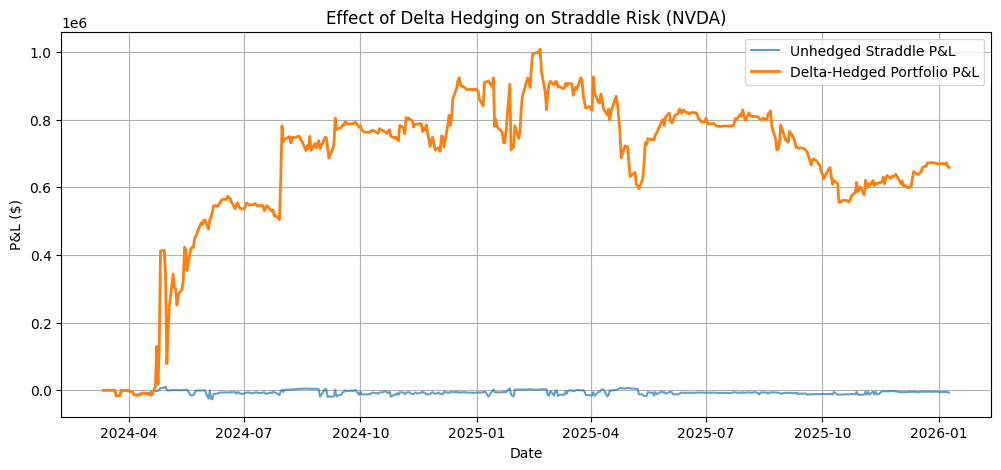

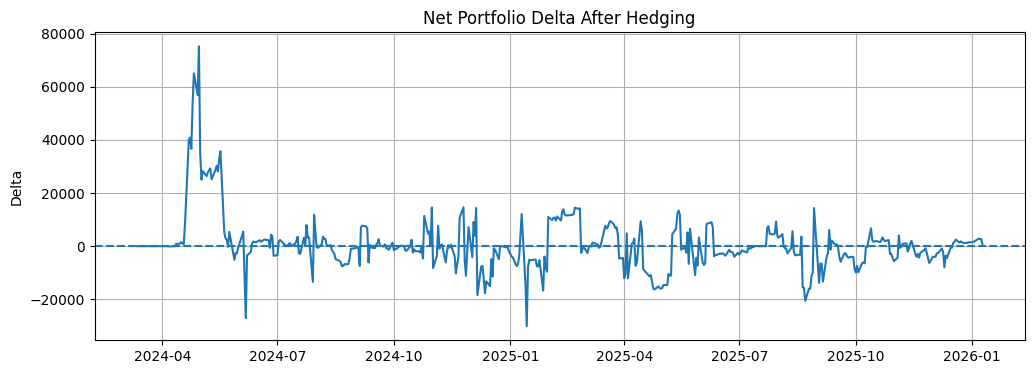

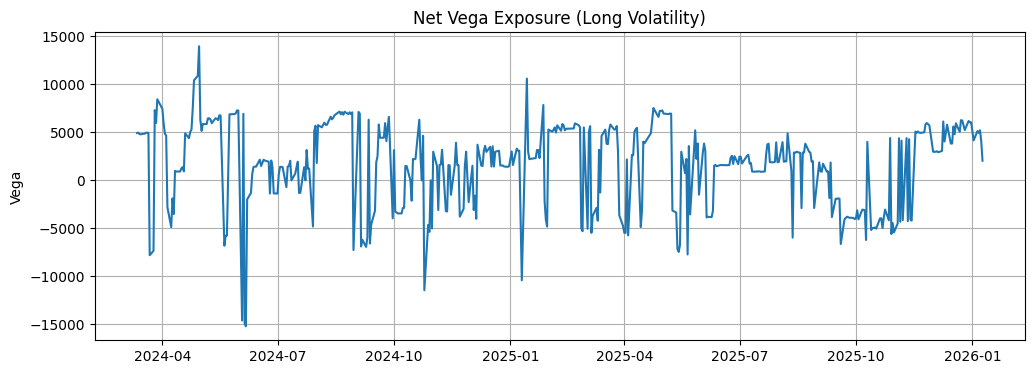

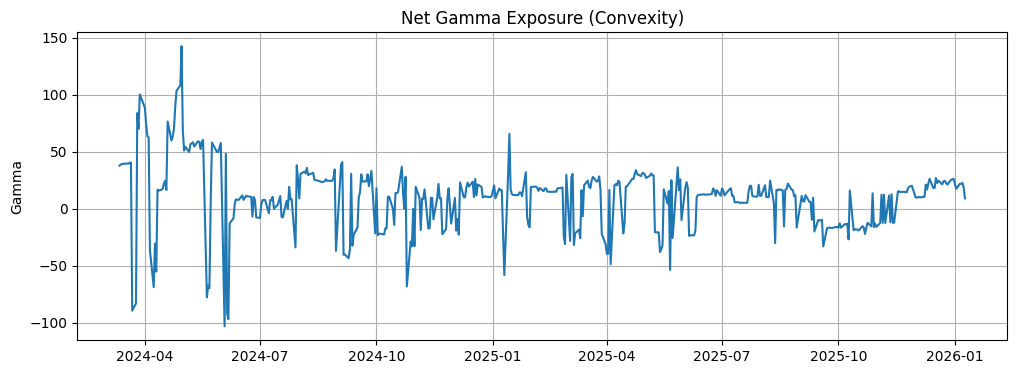

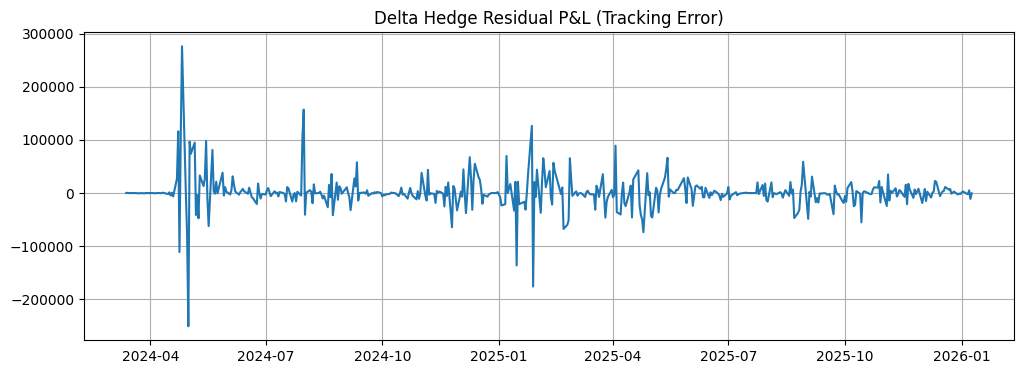

,Date,Stock,Strike,Regime,Straddle,Delta,Gamma,Vega,Theta,Hedge Multiplier,...,Shares Held,Shares Traded,Cash,Stock Value,Option Value,Portfolio,Return,Net_Delta,Net_Vega,Net_Gamma
0,2024-03-12,91.866135,90,Vol_Expansion,8.214403,0.196408,0.037841,4.920816,-103.075830,1.0,...,-196.407675,-196.407675,1.018043e+06,-18043.213897,8214.402709,1.008214e+06,NaN,0.0,4920.815705,37.841307
1,2024-03-13,90.841660,90,Vol_Expansion,8.095564,0.117435,0.038836,4.964316,-104.537269,1.0,...,-117.435012,78.972663,1.010869e+06,-10667.991353,8095.563530,1.008297e+06,0.000082,0.0,4964.315801,38.836241
2,2024-03-14,87.899147,90,Vol_Expansion,8.261012,-0.112245,0.039321,4.808075,-103.445516,1.0,...,112.245449,229.680461,9.906805e+05,9866.279257,8261.011760,1.008808e+06,0.000507,0.0,4808.075303,39.320695
3,2024-03-15,87.792213,90,Vol_Expansion,8.260176,-0.121006,0.039371,4.794414,-102.978363,1.0,...,121.006377,8.760927,9.899113e+05,10623.417644,8260.175544,1.008795e+06,-0.000013,0.0,4794.413523,39.370656
4,2024-03-18,88.409889,90,Vol_Expansion,8.135281,-0.073675,0.039706,4.863588,-103.614541,1.0,...,73.675133,-47.331243,9.940959e+05,6513.610382,8135.280668,1.008745e+06,-0.000050,0.0,4863.587696,39.705508
5,2024-03-19,89.352417,90,Vol_Expansion,8.090560,0.000873,0.039506,4.936495,-105.030846,1.0,...,-0.873435,-74.548568,1.000757e+06,-78.043485,8090.560299,1.008770e+06,0.000025,0.0,4936.494962,39.506411
6,2024-03-20,90.325920,90,Vol_Expansion,7.807329,0.076803,0.040505,4.967144,-101.493723,1.0,...,-76.803310,-75.929875,1.007615e+06,-6937.329605,7807.328759,1.008485e+06,-0.000282,0.0,4967.144339,40.505057
7,2024-03-21,91.388374,90,Vol_Expansion,7.743023,0.163680,0.040368,4.942363,-98.494944,1.0,...,-163.680452,-86.877142,1.015555e+06,-14958.490411,7743.022762,1.008340e+06,-0.000145,0.0,4942.363420,40.367622
8,2024-03-22,94.240921,95,Vol_Expansion,5.379309,-0.051093,0.059542,5.195897,-69.403285,1.0,...,-76.639539,87.040913,1.007352e+06,-7222.580733,-8068.963103,9.920606e+05,-0.016144,0.0,-7793.845458,-89.312635
9,2024-03-25,94.953552,95,Vol_Expansion,5.368665,0.033560,0.059213,5.241305,-69.952002,1.0,...,46.984321,123.623860,9.956136e+05,4461.328175,-7516.130804,9.925588e+05,0.000502,0.0,-7337.827678,-82.898000


,Date,Stock,Strike,Regime,Straddle,Delta,Gamma,Vega,Theta,Hedge Multiplier,...,Shares Held,Shares Traded,Cash,Stock Value,Option Value,Portfolio,Return,Net_Delta,Net_Vega,Net_Gamma
450,2025-12-26,190.529999,190,Trend,7.482743,0.080237,0.042363,10.473037,-96.959878,0.6,...,1144.536853,-267.330935,1.459582e+06,218068.605204,3741.371456,1.681392e+06,0.001038,1184.655309,5236.518436,21.181472
451,2025-12-29,188.220001,190,Trend,7.573810,-0.116090,0.042362,10.288423,-95.885804,0.6,...,1411.254977,266.718124,1.409381e+06,265626.413560,4544.285977,1.679551e+06,-0.001095,1341.601140,6173.053946,25.416906
452,2025-12-30,187.539993,190,Trend,7.485912,-0.178971,0.042994,10.099359,-91.696196,0.6,...,1686.385451,275.130474,1.357783e+06,316264.716153,4491.547170,1.678539e+06,-0.000603,1579.003050,6059.615385,25.796418
453,2025-12-31,186.500000,185,Trend,7.201274,0.168690,0.043779,10.072510,-90.576116,0.6,...,1301.607737,-384.777714,1.429544e+06,242749.842952,4320.764316,1.676614e+06,-0.001147,1402.821834,6043.505978,26.267271
454,2026-01-02,188.850006,190,Range,7.291277,-0.065757,0.043862,10.398039,-93.958685,1.2,...,1660.210610,358.602873,1.361822e+06,313530.783853,2916.510806,1.678269e+06,0.000987,1633.907965,4159.215582,17.544928
455,2026-01-05,188.119995,190,Range,7.303710,-0.131026,0.043950,10.252705,-91.877592,1.2,...,2546.993983,886.783373,1.195000e+06,479140.495709,3651.855069,1.677792e+06,-0.000284,2481.480759,5126.352605,21.974909
456,2026-01-06,187.240005,185,Range,7.164019,0.238030,0.043800,9.880730,-86.431111,1.2,...,2709.333837,162.339854,1.164603e+06,507295.682579,3582.009612,1.675481e+06,-0.001378,2828.348914,4940.365049,21.899810
457,2026-01-07,189.110001,190,Range,7.061252,-0.045420,0.045231,10.430923,-91.441741,1.2,...,2709.002451,-0.331386,1.164666e+06,512299.455182,3530.626127,1.680496e+06,0.002993,2686.292542,5215.461327,22.615262
458,2026-01-08,185.039993,185,Crash,6.994624,0.038675,0.045437,10.210986,-91.106825,1.5,...,2697.980624,-11.021827,1.166705e+06,499234.316496,2797.849550,1.668738e+06,-0.006997,2713.450475,4084.394337,18.174935
459,2026-01-09,184.860001,185,Crash,6.984904,0.022294,0.045545,10.209067,-91.034536,1.5,...,856.981279,-1840.999344,1.507033e+06,158421.559817,1396.980781,1.666851e+06,-0.001130,861.439980,2041.813314,9.108978


In [30]:
# =========================================================
# FINAL PART 2: VOL ARB FUND ENGINE (HARDENED)
# Min-Variance Hedge + Regime Risk Control + Vol Targeting
# =========================================================

from scipy.stats import norm

# ---------- Black–Scholes Straddle ----------
def bs_straddle(S, K, T, r, sigma):
    S = S.item() if isinstance(S, pd.Series) else S
    K = K.item() if isinstance(K, pd.Series) else K
    sigma = sigma.item() if isinstance(sigma, pd.Series) else sigma

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    put  = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    delta = norm.cdf(d1) - norm.cdf(-d1)
    gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
    vega  = S*norm.pdf(d1)*np.sqrt(T)
    theta = -(S*norm.pdf(d1)*sigma)/(2*np.sqrt(T))
    return call+put, delta, gamma, vega, theta

# ---------- Risk Parameters ----------
target_vol = 0.12
cvar_limit = 0.04
max_gamma_risk = 0.0005
max_vega_risk  = 0.02

hedge_mult = {
    "Range": 1.2,
    "Trend": 0.6,
    "Vol_Expansion": 1.0,
    "Crash": 1.5
}

initial_capital = 1_000_000
capital = initial_capital
cash = initial_capital
shares = 0
contracts = 0
roll_freq = 1   # CHANGED: Daily hedge

portfolio = []
trade_log = []
opt_returns = []
stk_returns = []

initial_S = data["Close"].iloc[252].item()
K = round(initial_S/5)*5
expiry = data.index[252] + pd.Timedelta(days=7)

for i in range(252, len(data)):

    # ----- HARD DRAWDOWN STOP -----
    if capital < 0.75 * initial_capital:
        contracts = 0
        shares = 0
        continue

    date = data.index[i]
    S = data["Close"].iloc[i].item()
    r = 0.05
    sigma_impl = data["implied_vol_proxy"].iloc[i].item()
    vol_f = data["garch_vol_forecast"].iloc[i].item()
    vrp_z = data["VRP_Z"].iloc[i].item()
    regime = data["Regime_Label"].iloc[i]

    if regime not in hedge_mult:
        continue

    if i % roll_freq == 0:
        K = round(S/5)*5
        expiry = date + pd.Timedelta(days=7)

    T = max((expiry - date).days/365, 1/365)
    price, delta, gamma, vega, theta = bs_straddle(S, K, T, r, sigma_impl)

    # ----- REGIME RISK SCALING -----
    if regime in ["Crash", "Vol_Expansion"]:
        vol_regime_scale = 0.4
    elif regime == "Trend":
        vol_regime_scale = 0.7
    else:
        vol_regime_scale = 1.0

    gamma_weight = np.tanh(1.2 * vrp_z)

    vol_edge = vol_f**2 - sigma_impl**2
    vol_var = data["garch_vol_forecast"].rolling(60).var().iloc[i].item()
    kelly = 0.25 * (vol_edge / vol_var) if vol_var > 0 else 0
    kelly = np.clip(kelly, -0.15, 0.15)

    notional = capital * kelly
    raw_contracts = (notional / (price * 100)) * gamma_weight * vol_regime_scale

    gamma_risk = abs(raw_contracts * gamma * 100)
    vega_risk  = abs(raw_contracts * vega  * 100)

    # ----- TAIL RISK KILL SWITCH -----
    if regime == "Crash":
        raw_contracts *= 0.3
    if gamma_risk > 0.5 * max_gamma_risk * capital:
        raw_contracts *= 0.5
    if vega_risk > 0.5 * max_vega_risk * capital:
        raw_contracts *= 0.5

    if gamma_risk > max_gamma_risk * capital:
        raw_contracts *= (max_gamma_risk * capital) / gamma_risk
    if vega_risk > max_vega_risk * capital:
        raw_contracts *= (max_vega_risk * capital) / vega_risk

    if len(portfolio) > 60:
        realized_vol = np.std(np.diff(portfolio[-60:]) / portfolio[-60:-1]) * np.sqrt(252)
        if realized_vol > 0:
            vol_scale = target_vol / realized_vol
            raw_contracts *= vol_scale

    contracts = int(np.clip(raw_contracts, -40, 40))

    if len(opt_returns) > 20:
        cov = np.cov(opt_returns[-20:], stk_returns[-20:])[0,1]
        var = np.var(stk_returns[-20:])
        h_star = cov / var if var > 0 else delta
    else:
        h_star = delta

    hedge_ratio = hedge_mult[regime] * h_star
    target_shares = -hedge_ratio * contracts * 100
    trade = target_shares - shares
    cash -= trade * S
    shares = target_shares

    option_value = contracts * price * 100
    stock_value = shares * S
    capital = cash + stock_value + option_value

    portfolio.append(capital)

    if len(trade_log) > 0 and trade_log[-1]["Option Value"] != 0:
        opt_returns.append((option_value - trade_log[-1]["Option Value"]) / trade_log[-1]["Option Value"])
        stk_returns.append((S - data["Close"].iloc[i-1].item()) / data["Close"].iloc[i-1].item())

    trade_log.append({
        "Date": date,
        "Stock": S,
        "Strike": K,
        "Regime": regime,
        "Straddle": price,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Hedge Multiplier": hedge_mult[regime],
        "Contracts": contracts,
        "Hedge Ratio": hedge_ratio,
        "Shares Held": shares,
        "Shares Traded": trade,
        "Cash": cash,
        "Stock Value": stock_value,
        "Option Value": option_value,
        "Portfolio": capital
    })

trade_df = pd.DataFrame(trade_log)
trade_df["Return"] = trade_df["Portfolio"].pct_change()

excess = trade_df["Return"].dropna()
sharpe = np.sqrt(252) * excess.mean() / excess.std()
cum = (1 + trade_df["Return"].fillna(0)).cumprod()
dd = cum / cum.cummax() - 1
max_dd = dd.min()
cagr = (cum.iloc[-1] ** (252/len(cum)) - 1)

print("\n================ VOL ARB FUND PERFORMANCE ================")
print(f"Sharpe Ratio   : {sharpe:.2f}")
print(f"CAGR           : {cagr*100:.2f}%")
print(f"Max Drawdown   : {max_dd*100:.2f}%")
print(f"Final Capital  : ${capital:,.0f}")
print("=========================================================")

unhedged_pnl = trade_df["Option Value"] - trade_df["Option Value"].iloc[0]
hedged_pnl   = trade_df["Portfolio"] - trade_df["Portfolio"].iloc[0]

plt.figure(figsize=(12,5))
plt.plot(trade_df["Date"], unhedged_pnl, label="Unhedged Straddle P&L", alpha=0.7)
plt.plot(trade_df["Date"], hedged_pnl, label="Delta-Hedged Portfolio P&L", linewidth=2)

plt.title("Effect of Delta Hedging on Straddle Risk (NVDA)")
plt.xlabel("Date")
plt.ylabel("P&L ($)")
plt.legend()
plt.grid(True)
plt.show()

trade_df["Net_Delta"] = trade_df["Delta"] * trade_df["Contracts"] * 100 + trade_df["Shares Held"]

plt.figure(figsize=(12,4))
plt.plot(trade_df["Date"], trade_df["Net_Delta"])
plt.axhline(0, linestyle="--")
plt.title("Net Portfolio Delta After Hedging")
plt.ylabel("Delta")
plt.grid(True)
plt.show()
trade_df["Net_Vega"] = trade_df["Vega"] * trade_df["Contracts"] * 100

plt.figure(figsize=(12,4))
plt.plot(trade_df["Date"], trade_df["Net_Vega"])
plt.title("Net Vega Exposure (Long Volatility)")
plt.ylabel("Vega")
plt.grid(True)
plt.show()
trade_df["Net_Gamma"] = trade_df["Gamma"] * trade_df["Contracts"] * 100

plt.figure(figsize=(12,4))
plt.plot(trade_df["Date"], trade_df["Net_Gamma"])
plt.title("Net Gamma Exposure (Convexity)")
plt.ylabel("Gamma")
plt.grid(True)
plt.show()
hedge_error = (trade_df["Shares Held"].shift(1) *
               (trade_df["Stock"] - trade_df["Stock"].shift(1)))

plt.figure(figsize=(12,4))
plt.plot(trade_df["Date"], hedge_error)
plt.title("Delta Hedge Residual P&L (Tracking Error)")
plt.grid(True)
plt.show()

display(trade_df.head(10))
display(trade_df.tail(10))
trade_df.to_csv("NVDA_VolArb_Fund_Final.csv", index=False)


[*********************100%***********************]  1 of 1 completed


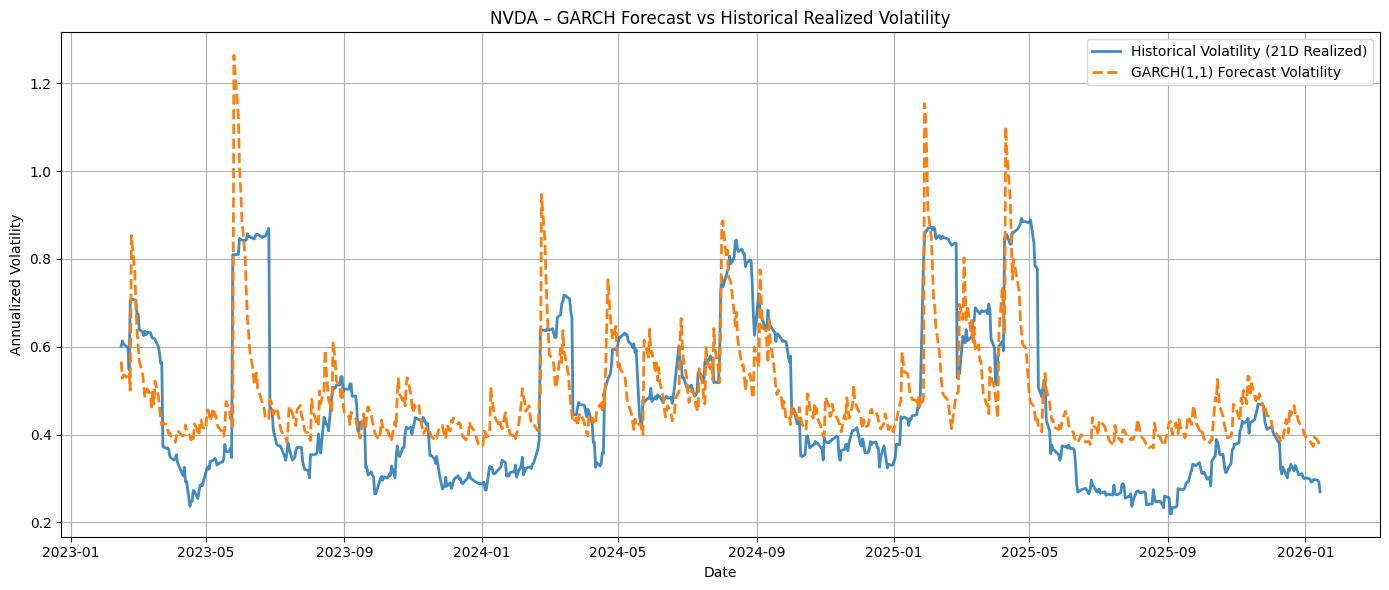

In [2]:
# =========================================================
# GARCH vs HISTORICAL (REALIZED) VOLATILITY – NVDA
# Fully consistent with your uploaded pipeline
# =========================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model

# -------------------------
# Reload NVDA data (3Y)
# -------------------------
ticker = "NVDA"
data = yf.download(ticker, period="3y", auto_adjust=True)

# -------------------------
# Compute returns & realized vol (same as your code)
# -------------------------
data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
data["realized_vol"] = data["log_return"].rolling(21).std() * np.sqrt(252)
data.dropna(inplace=True)

# -------------------------
# Fit GARCH(1,1) (same settings)
# -------------------------
returns = data["log_return"] * 100
garch = arch_model(returns, vol="Garch", p=1, q=1, dist="normal")
garch_fit = garch.fit(disp="off")

# Annualized conditional volatility
data["garch_vol_forecast"] = (
    garch_fit.conditional_volatility * np.sqrt(252) / 100
)

# -------------------------
# Plot comparison
# -------------------------
plt.figure(figsize=(14,6))

plt.plot(
    data.index,
    data["realized_vol"],
    label="Historical Volatility (21D Realized)",
    linewidth=2,
    alpha=0.85
)

plt.plot(
    data.index,
    data["garch_vol_forecast"],
    label="GARCH(1,1) Forecast Volatility",
    linestyle="--",
    linewidth=2
)

plt.title("NVDA – GARCH Forecast vs Historical Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
